# Statistical Insights into Credit Behavior: An Inferential Approach using German Credit Data

This project investigates credit behavior across different client demographics using inferential statistics.
We aim to identify whether variables such as gender, age, and employment type are associated with significant differences in credit default rates, loan amounts, and loan durations.
By applying hypothesis testing and correlation analysis, we seek to uncover meaningful patterns in the data.
The final objective is to support data-informed decisions in fair and responsible credit lending.

The dataset contains information about 1000 individuals who applied for credit at a German bank. Each row represents one customer, and the columns include demographic, financial, and credit-related information.

**Column Name	Description**

- **Age**:	Age of the customer (in years)
- **Sex**:	Gender of the customer (Male/Female)
- **Job**:	Job category (numeric: 0 - unskilled and non-resident, 1 - unskilled and resident, 2 - skilled, 3 - highly skilled)
- **Housing**:	Type of housing (own / rent / free)
- **Saving accounts**:	Savings level (little / moderate / quite rich / rich)
- **Checking account**:	Checking account status (none / little / moderate / rich)
- **Credit amount**:	Amount of credit applied for
- **Duration**:	Loan duration (in months)
- **Purpose**:	Purpose of the credit (car / furniture / radio/TV / business / education…)
- **Risk**:	Target variable: 1 = good credit, 0 = bad credit (defaulted)

### Libraries

In [10]:
from IPython.display import HTML
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import mannwhitneyu
from scipy.stats import kruskal
from scipy.stats import shapiro
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import chi2_contingency

### Dataset Import

In [11]:
df = pd.read_csv("German_credit_risk.csv")
HTML("" + df.head().to_html() + "")

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,2,49,male,1,own,little,NaN,2096,12,education,good
3,3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,4,53,male,2,free,little,little,4870,24,car,bad


In [12]:
# Remove non necessary column
df = df.drop(columns=['Unnamed: 0'])

### Missing Values

In [13]:
print(df.info())
print(df.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Saving accounts   817 non-null    object
 5   Checking account  606 non-null    object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
 9   Risk              1000 non-null   object
dtypes: int64(4), object(6)
memory usage: 78.3+ KB
None
(1000, 10)


In [14]:
# Null entries by variable
null_counts = df.isnull().sum()
null_percent = 100 * null_counts / len(df)

missing_data = pd.DataFrame({
    'Null Count': null_counts,
    'Null Percentage (%)': null_percent
})

print(missing_data)


                  Null Count  Null Percentage (%)
Age                        0                  0.0
Sex                        0                  0.0
Job                        0                  0.0
Housing                    0                  0.0
Saving accounts          183                 18.3
Checking account         394                 39.4
Credit amount              0                  0.0
Duration                   0                  0.0
Purpose                    0                  0.0
Risk                       0                  0.0


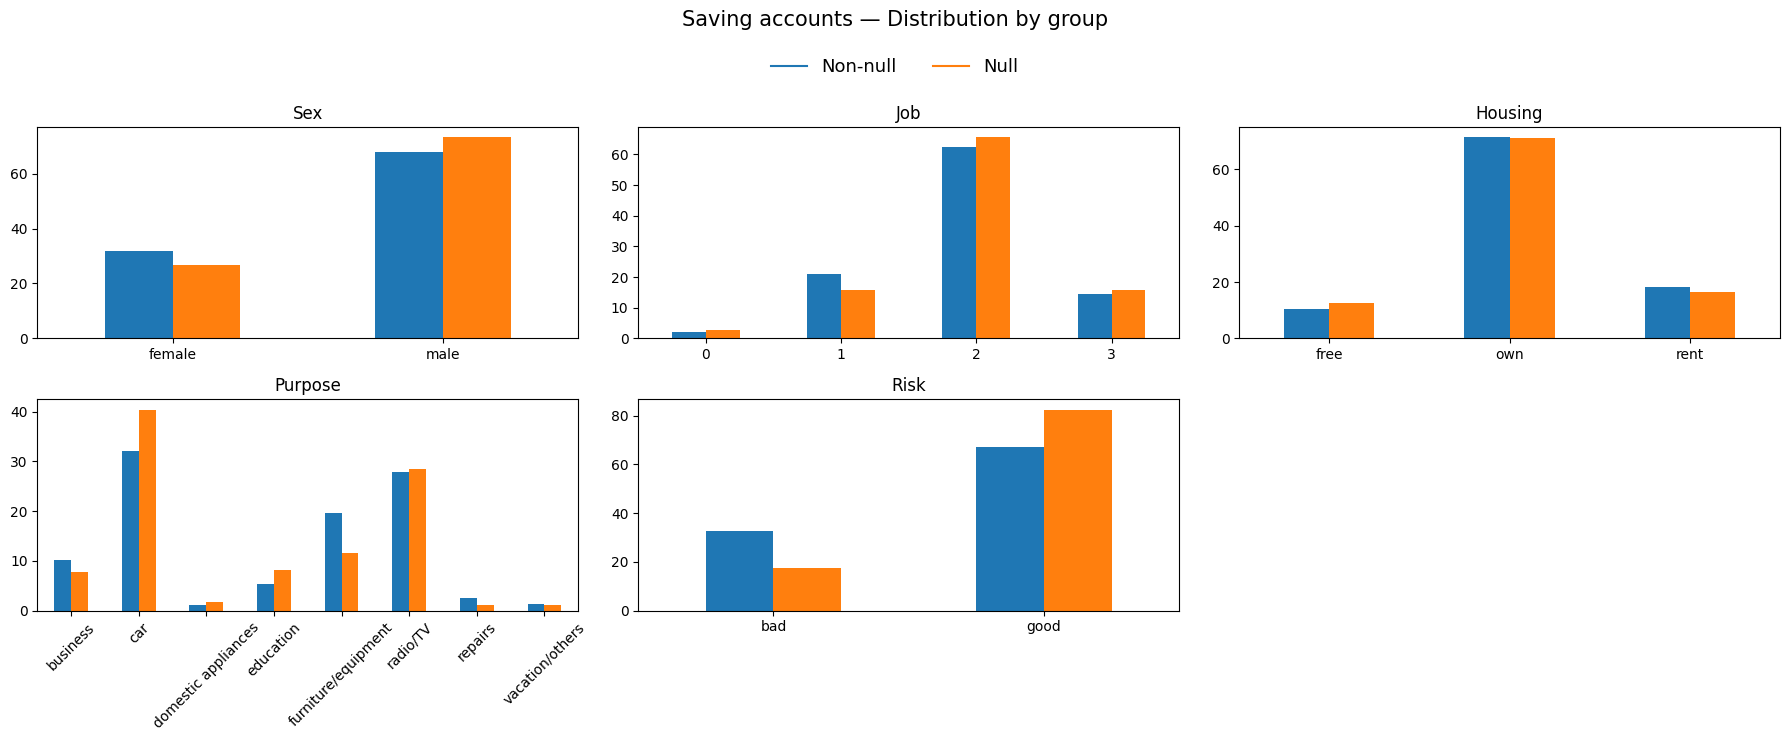

In [15]:
# Categorical columns
cat_cols = ['Sex', 'Job', 'Housing', 'Purpose', 'Risk']

# Flag nulls (group = Null / Non-null)
df['sa_is_null'] = df['Saving accounts'].isna().map({True: 'Null', False: 'Non-null'})

# Subplots
rows, cols = 2, 3
fig, axes = plt.subplots(rows, cols, figsize=(18, 8))
axes = axes.ravel()

for i, col in enumerate(cat_cols):
    # P(category | group): each row (group) sums to 100%
    tab = pd.crosstab(df['sa_is_null'], df[col], normalize='index') * 100
    # Plot categories on x-axis; legend will be groups (Null / Non-null) after .T
    tab.T.plot(kind='bar', ax=axes[i], legend=False)
    axes[i].set_title(col)
    axes[i].set_ylabel('% of group')
    axes[i].set_xlabel('')
    axes[i].tick_params(axis='x', rotation=45 if col == 'Purpose' else 0)
    axes[i].set_ylabel(None)

# Remove the last empty subplot
fig.delaxes(axes[-1])

# Reserve space for title + legend
plt.tight_layout(rect=[0, 0, 1, 0.82])

# Shared title
fig.suptitle("Saving accounts — Distribution by group",
             fontsize=15, y=0.92)

# Shared legend (groups: Null / Non-null)
handles, labels = tab.T.plot(legend=True).get_legend_handles_labels()
plt.close()  # close the extra figure created just to get legend handles
fig.legend(handles, labels,
           loc='upper center', ncol=2, frameon=False,
           bbox_to_anchor=(0.5, 0.88), fontsize=13)

plt.show()


The missing values could origin from empty saving accounts. However, this hypothesis seems unlikely:

* Considering the main categories involved, good borrowers and house owners are not expected to have zero savings. Similarly, skilled workers usually have higher saving capacity due to higher salaries.  
* The distributions of missing vs. non-missing values follow very similar patterns, with only minor differences, suggesting that missingness is not strongly linked to any specific category.  
* Overall, missing values are most likely **Missing Completely at Random (MCAR)**.

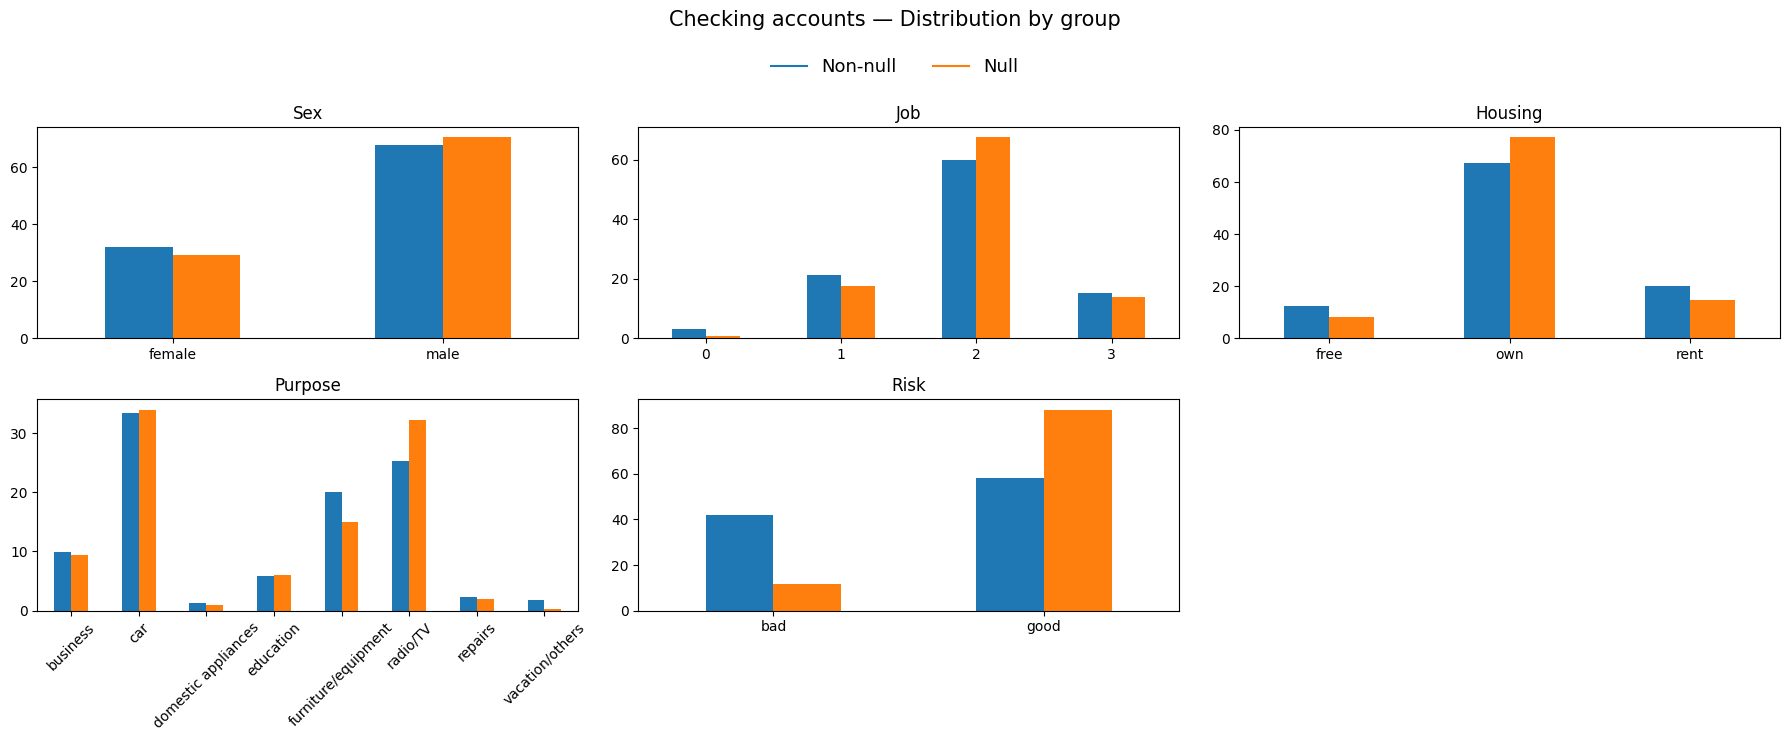

In [16]:
# Categorical columns
cat_cols = ['Sex', 'Job', 'Housing', 'Purpose', 'Risk']

# Flag nulls (group = Null / Non-null)
df['ca_is_null'] = df['Checking account'].isna().map({True: 'Null', False: 'Non-null'})

# Subplots
rows, cols = 2, 3
fig, axes = plt.subplots(rows, cols, figsize=(18, 8))
axes = axes.ravel()

for i, col in enumerate(cat_cols):
    # P(category | group): each row (group) sums to 100%
    tab = pd.crosstab(df['ca_is_null'], df[col], normalize='index') * 100
    # Plot categories on x-axis; legend will be groups (Null / Non-null) after .T
    tab.T.plot(kind='bar', ax=axes[i], legend=False)
    axes[i].set_title(col)
    axes[i].set_ylabel('% of group')
    axes[i].set_xlabel('')
    axes[i].tick_params(axis='x', rotation=45 if col == 'Purpose' else 0)
    axes[i].set_ylabel(None)

# Remove the last empty subplot
fig.delaxes(axes[-1])

# Reserve space for title + legend
plt.tight_layout(rect=[0, 0, 1, 0.82])

# Shared title
fig.suptitle("Checking accounts — Distribution by group",
             fontsize=15, y=0.92)

# Shared legend (groups: Null / Non-null)
handles, labels = tab.T.plot(legend=True).get_legend_handles_labels()
plt.close()  # close the extra figure created just to get legend handles
fig.legend(handles, labels,
           loc='upper center', ncol=2, frameon=False,
           bbox_to_anchor=(0.5, 0.88), fontsize=13)

plt.show()


The same reasoning applies to missing checking account balances.  
Therefore, these missing values are more likely to result from **data entry errors** rather than actual absence of an account.  


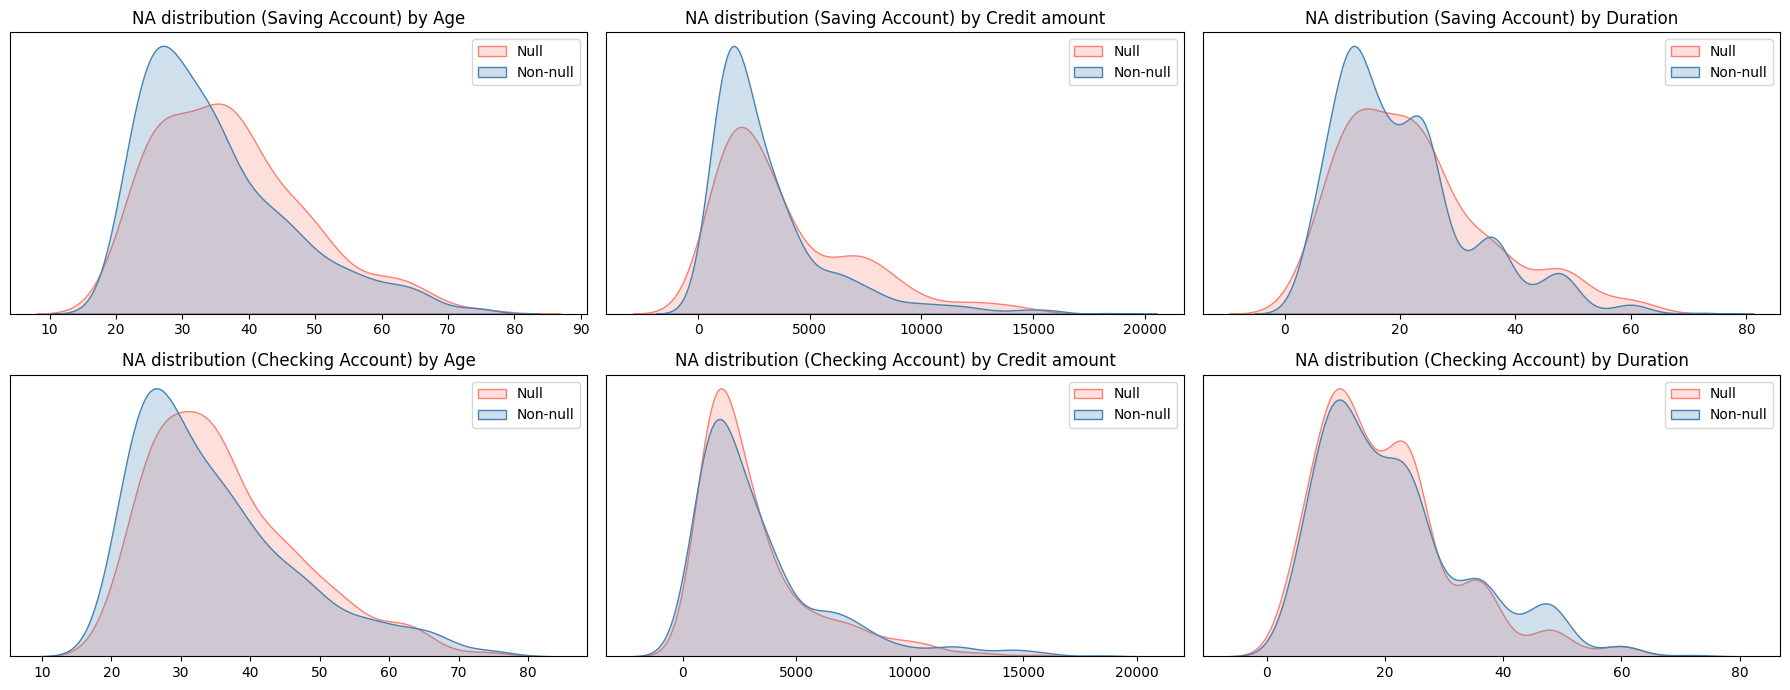

In [17]:
null_cols = missing_data.loc[missing_data['Null Count'] > 0].index
num_cols = ['Age', 'Credit amount', 'Duration']

# Density plot
plt.figure(figsize=(18, 7))

for nc in ['Saving accounts', 'Checking account']:
  for i, col in enumerate(num_cols, 1):
    null_df = df.loc[df[nc].isnull()]
    non_null_df = df.loc[~df[nc].isnull()]
    if nc == 'Saving accounts':
      plt.subplot(2, 3, i)
      sns.kdeplot(data=null_df, x=col, fill=True, color='salmon', label = 'Null')
      sns.kdeplot(data=non_null_df, x=col, fill=True, color='steelblue', label = 'Non-null')
      plt.ylabel(None)
      plt.xlabel(None)
      plt.yticks([])
      plt.title(f"NA distribution (Saving Account) by {col}")
      plt.legend()
    else:
      plt.subplot(2, 3, i+3)
      sns.kdeplot(data=null_df, x=col, fill=True, color='salmon', label='Null')
      sns.kdeplot(data=non_null_df, x=col, fill=True, color='steelblue', label = 'Non-null')
      plt.ylabel(None)
      plt.xlabel(None)
      plt.yticks([])
      plt.title(f"NA distribution (Checking Account) by {col}")
      plt.legend()

plt.tight_layout()
plt.show()


* The distributions of records with missing values are very similar to those without missing values, for both **Saving accounts** and **Checking accounts**.  
* The likelihood of a record being missing appears independent of these variables, suggesting the data are **Missing Completely at Random (MCAR)**.  
* The missingness is therefore most likely attributable to incomplete or inaccurate data collection.  


### Exploratory Data Analysis (EDA)

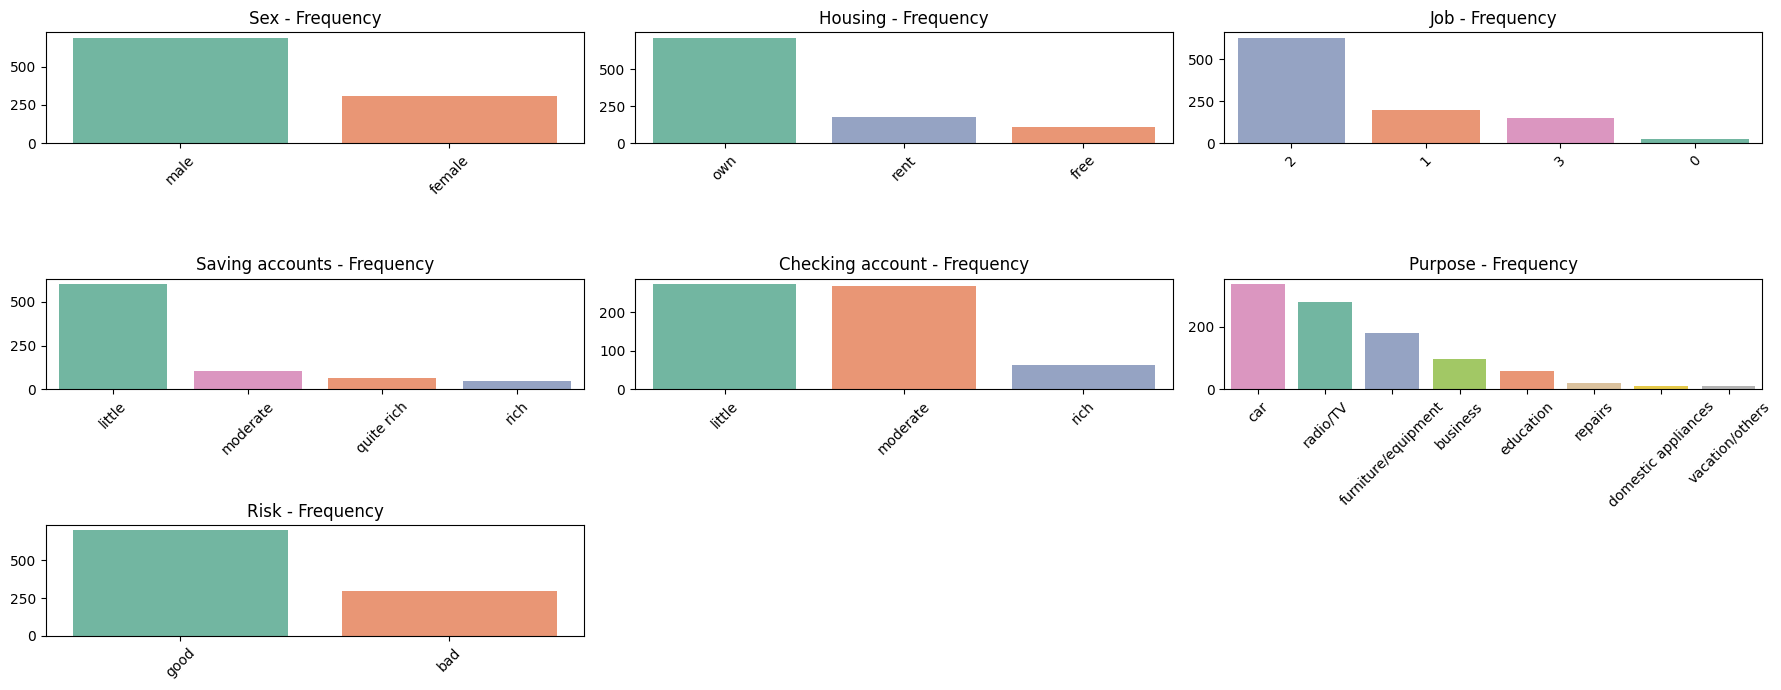

In [18]:
categorical_cols = ['Sex', 'Housing', 'Job', 'Saving accounts', 'Checking account', 'Purpose', 'Risk']

fig, axes = plt.subplots(3, 3, figsize=(18, 7))
axes = axes.flatten()

for i, col in enumerate(categorical_cols):
    sns.countplot(data=df, x=col, order=df[col].value_counts().index, palette='Set2', ax=axes[i], hue=col, legend=False)
    axes[i].set_title(f"{col} - Frequency", fontsize=12)
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].set_xlabel(None)
    axes[i].set_ylabel(None)

# Hide remaining empty axes
for j in range(len(categorical_cols), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


* The dataset is **male-biased**, suggesting gender may not serve as a strong predictor of credit risk.  
* Most customers are **homeowners**, which often correlates with financial stability, whereas renters or those living rent-free may carry higher risk.  
* The majority of workers are **skilled**, while unskilled workers are underrepresented.  
* Most borrowers report **low savings**, a factor that may correlate with higher credit risk.  
* **Consumer goods** dominate as loan purposes, with **Car** and **Radio/TV** being the most common categories.  
* Credit risk is **moderately imbalanced**, so naive models may lean toward predicting low risk disproportionately.  


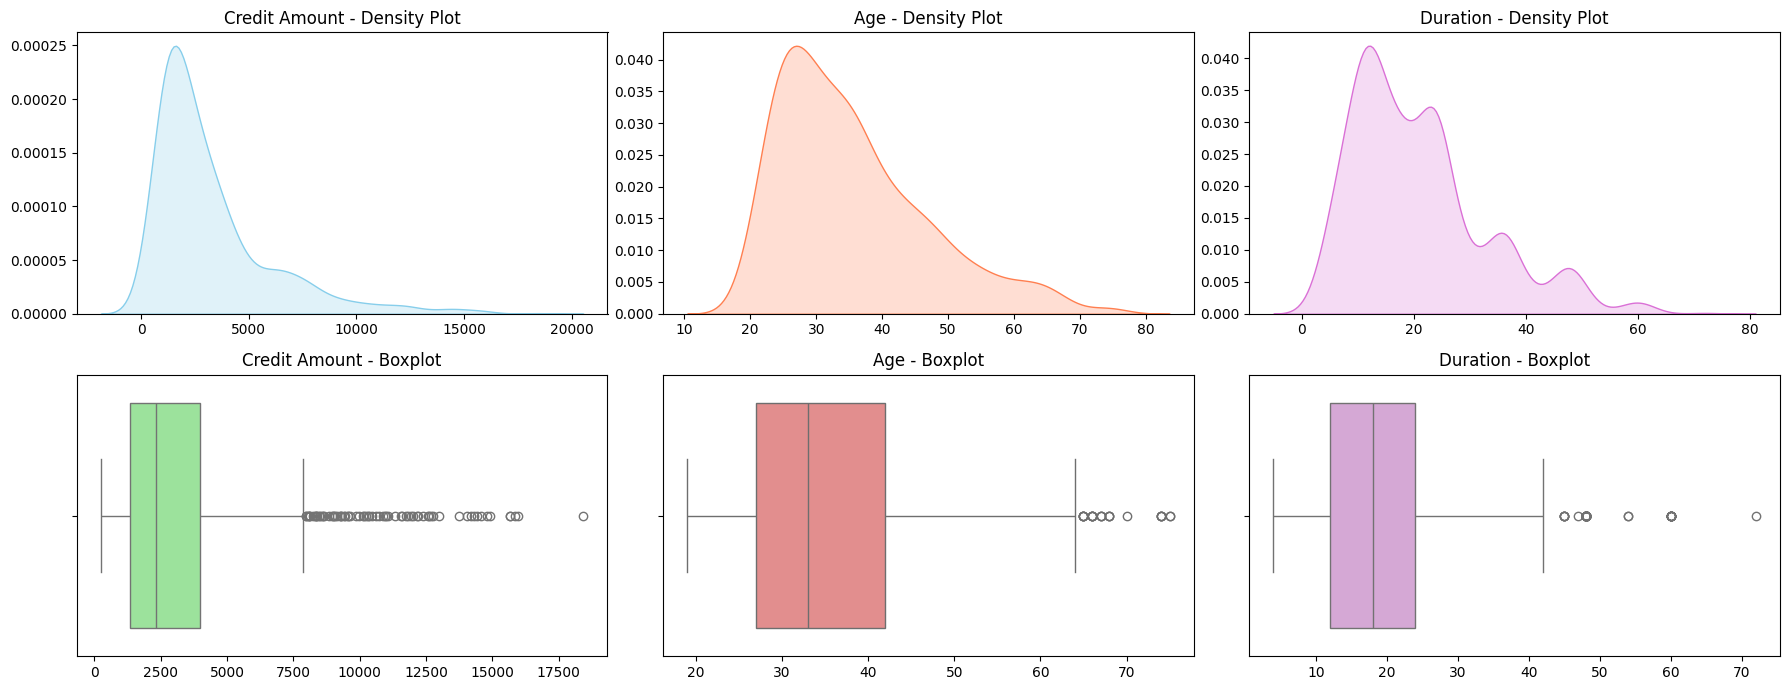

In [19]:
fig, axes = plt.subplots(2, 3, figsize=(18, 7))

# Credit amount
sns.kdeplot(df['Credit amount'], fill=True, ax=axes[0, 0], color='skyblue')
axes[0, 0].set_title('Credit Amount - Density Plot')
axes[0, 0].set_xlabel(None)
axes[0, 0].set_ylabel(None)

sns.boxplot(x=df['Credit amount'], ax=axes[1, 0], color='lightgreen')
axes[1, 0].set_title('Credit Amount - Boxplot')
axes[1, 0].set_xlabel(None)
axes[1, 0].set_ylabel(None)

# Age
sns.kdeplot(df['Age'], fill=True, ax=axes[0, 1], color='coral')
axes[0, 1].set_title('Age - Density Plot')
axes[0, 1].set_xlabel('Age')
axes[0, 1].set_xlabel(None)
axes[0, 1].set_ylabel(None)

sns.boxplot(x=df['Age'], ax=axes[1, 1], color='lightcoral')
axes[1, 1].set_title('Age - Boxplot')
axes[1, 1].set_xlabel(None)
axes[1, 1].set_ylabel(None)

# Duration
sns.kdeplot(df['Duration'], fill=True, ax=axes[0, 2], color='orchid')
axes[0, 2].set_title('Duration - Density Plot')
axes[0, 2].set_xlabel(None)
axes[0, 2].set_ylabel(None)


sns.boxplot(x=df['Duration'], ax=axes[1, 2], color='plum')
axes[1, 2].set_title('Duration - Boxplot')
axes[1, 2].set_xlabel(None)
axes[1, 2].set_ylabel(None)

plt.tight_layout()
plt.show()

* Most customers apply for **modest loan amounts**, but a small group request much higher sums. These outliers could bias risk estimates and may require a **log transformation** if used in modeling.  
* **Younger applicants** make up the majority, while older customers are fewer but potentially more financially stable.  
* Most loans are **short-term (12–24 months)**, with smaller peaks around 36 months and a long tail up to 72 months. Credit risk likely increases with **longer durations**, as extended repayment periods are harder to sustain.  


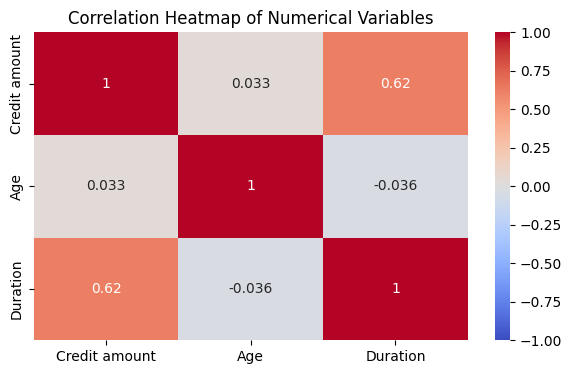

In [20]:
numerical_cols = ['Credit amount', 'Age', 'Duration']

# Correlation matrix
corr_matrix = df[numerical_cols].corr()

# Heatmap
plt.figure(figsize=(7,4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, vmin=-1, vmax=1)
plt.title('Correlation Heatmap of Numerical Variables')
plt.show()


As expected, higher credit amounts are associated with longer durations, which is typical loan behavior.  


### Statistical Analysis

**Does Gender Affect Credit Amount?**

In [21]:
# Gender frequency
counts = df['Sex'].value_counts(normalize=True)
print(counts)

Sex
male      0.69
female    0.31
Name: proportion, dtype: float64


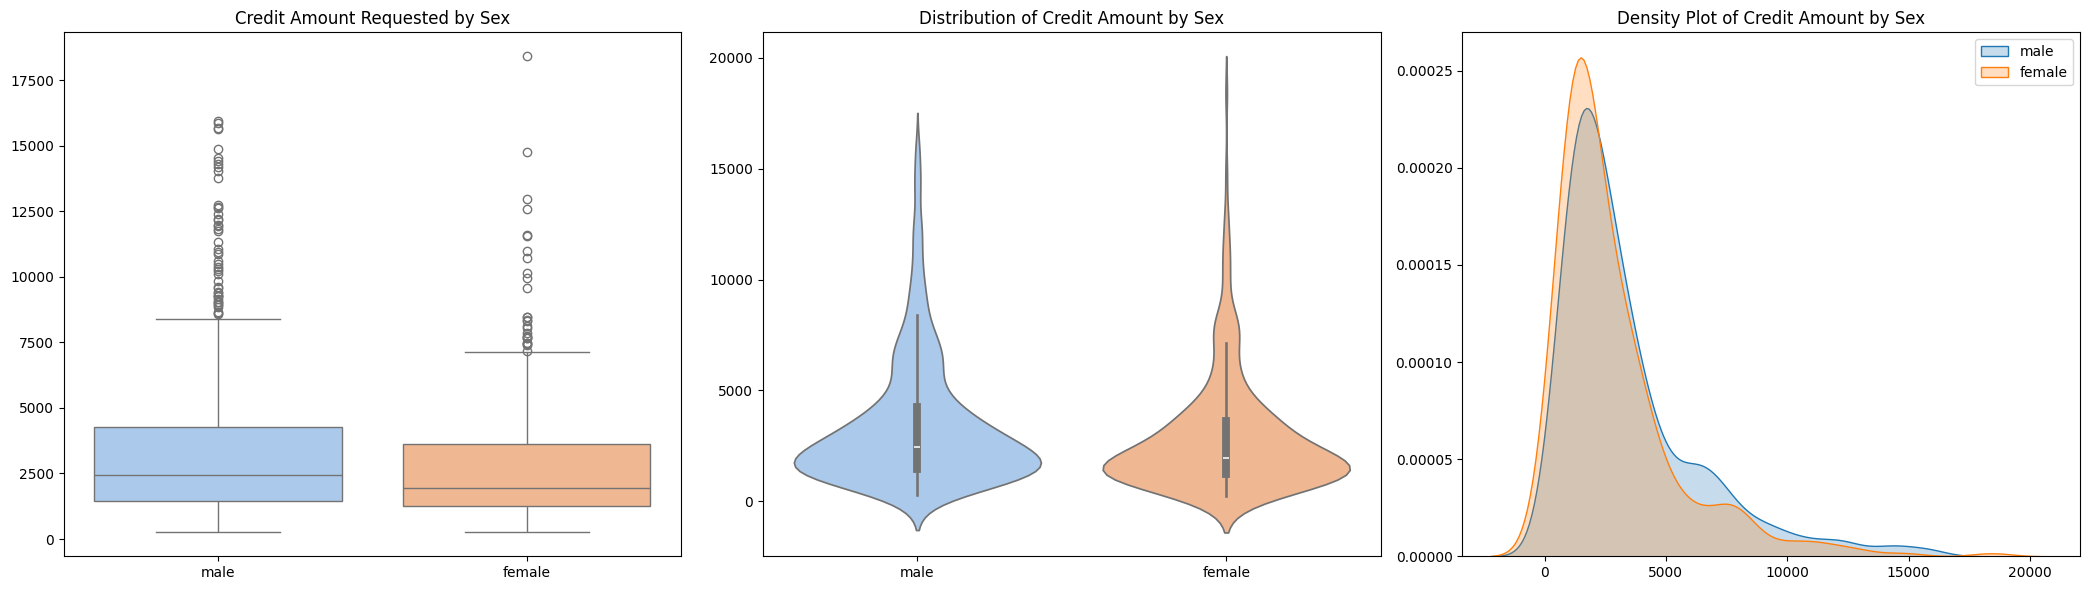

In [22]:
fig, axes = plt.subplots(1, 3, figsize=(21, 6))

# Boxplot of Credit Amount by Sex
sns.boxplot(data=df, x='Sex', y='Credit amount', palette='pastel', ax=axes[0], hue='Sex')
axes[0].set_title('Credit Amount Requested by Sex')
axes[0].set_xlabel(None)
axes[0].set_ylabel(None)

# Violin plot of Credit Amount by Sex
sns.violinplot(data=df, x='Sex', y='Credit amount', palette='pastel', ax=axes[1], hue='Sex')
axes[1].set_title('Distribution of Credit Amount by Sex')
axes[1].set_xlabel(None)
axes[1].set_ylabel(None)

# Density plot of Credit Amount by Sex
for sex in df['Sex'].unique():
    sns.kdeplot(df[df['Sex'] == sex]['Credit amount'], label=sex, fill=True, ax=axes[2])
axes[2].set_title('Density Plot of Credit Amount by Sex')
axes[2].legend()
axes[2].set_xlabel(None)
axes[2].set_ylabel(None)

plt.tight_layout()
plt.show()


Men appear to request **higher credit amounts** and show greater variability, while women are more concentrated in the lower ranges.

This observation can be tested statistically. To choose the appropriate test, we must first verify the assumptions of **normality** and **equal variances**.

**Shapiro–Wilk test**: Does the data follow a normal distribution?  
- H₀: The data follow a normal distribution  
- H₁: The data do not follow a normal distribution  

**Levene’s test**: Are the variances equal between the groups?  
- H₀: The variances are equal across groups  
- H₁: The variances are not equal across groups  


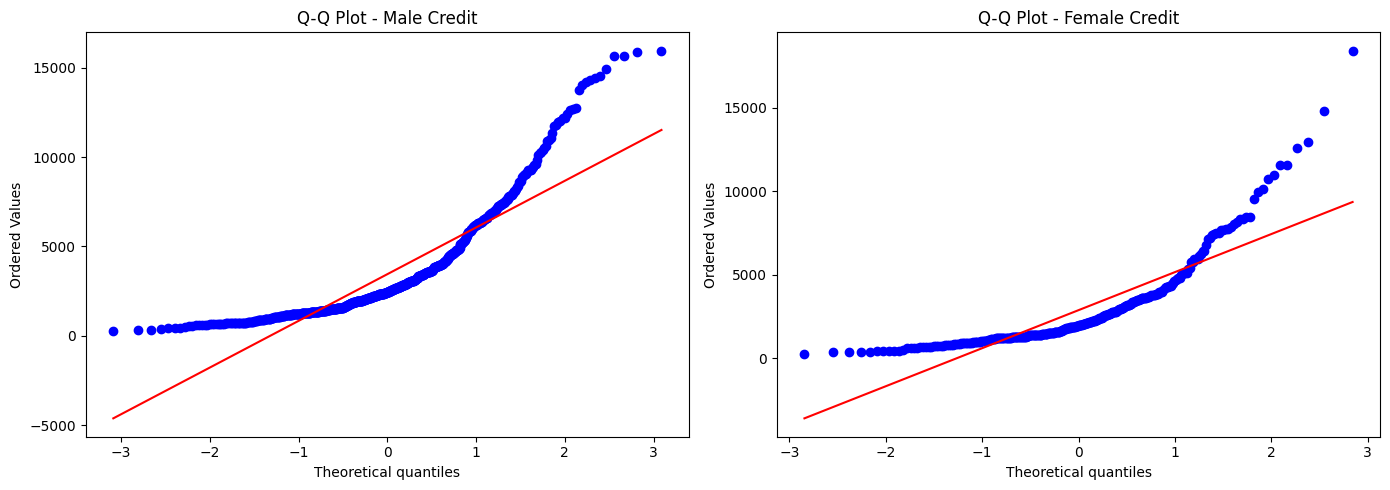


Male Shapiro p-value: 5.197994364733652e-28
Female Shapiro p-value: 6.289124488656574e-21


In [23]:
# QQ Plot

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

male_credit = df.loc[df['Sex'] == 'male','Credit amount']
female_credit = df.loc[df['Sex'] == 'female','Credit amount']

# Q-Q plot for Male Credit
stats.probplot(male_credit, dist="norm", plot=axes[0])
axes[0].set_title("Q-Q Plot - Male Credit")

# Q-Q plot for Female Credit
stats.probplot(female_credit, dist="norm", plot=axes[1])
axes[1].set_title("Q-Q Plot - Female Credit")

plt.tight_layout()
plt.show()

# Shapiro test

stat_m, p_m = stats.shapiro(male_credit)
stat_f, p_f = stats.shapiro(female_credit)
print(f"\nMale Shapiro p-value: {p_m}")
print(f"Female Shapiro p-value: {p_f}")

We reject the null hypothesis of normality: the distributions deviate significantly from normal.  
Therefore, the **t-test is not appropriate**, and we instead use the non-parametric **Mann–Whitney U test**:

- H₀: The distributions of the two independent groups are equal  
- H₁: The distributions of the two independent groups differ  


In [24]:
# Mann–Whitney U Test
stat, p = mannwhitneyu(male_credit, female_credit, alternative='two-sided')

print(f"Mann–Whitney U statistic: {stat}")
print(f"P-value: {p}")

Mann–Whitney U statistic: 122417.0
P-value: 0.00025073200547917737


* We reject the null hypothesis: the statistical evidence indicates that male and female applicants come from different credit amount distributions.  
* The results suggest that men and women generally request different credit amounts.  


**Does Homeownership Affect Credit Amount?**


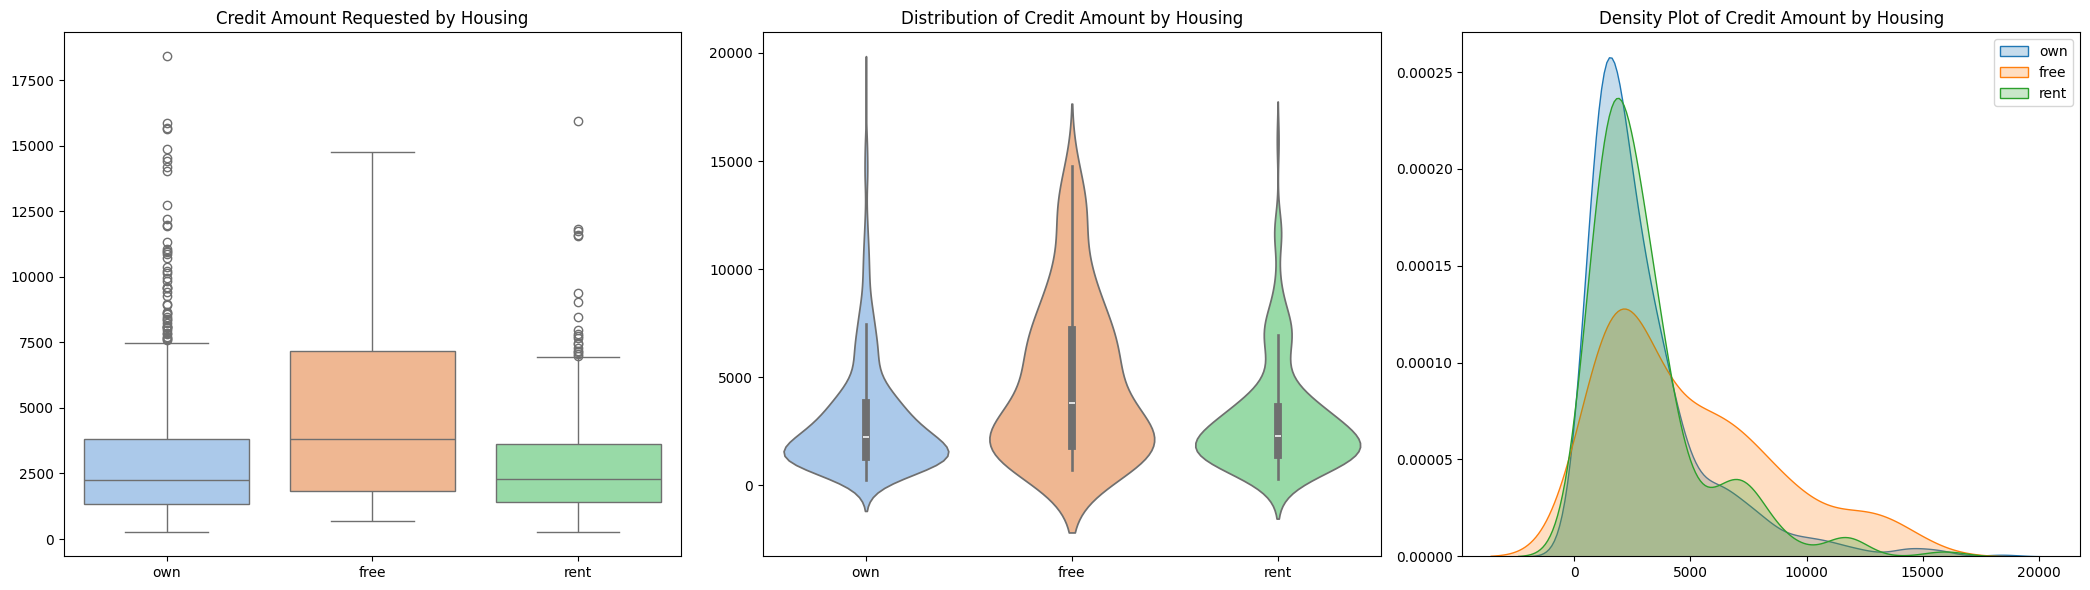

In [25]:
fig, axes = plt.subplots(1, 3, figsize=(21, 6))

# Boxplot of Credit Amount by Housing type
sns.boxplot(data=df, x='Housing', y='Credit amount', palette='pastel', ax=axes[0], hue='Housing')
axes[0].set_title('Credit Amount Requested by Housing')
axes[0].set_xlabel(None)
axes[0].set_ylabel(None)

# Violin plot of Credit Amount by Housing type
sns.violinplot(data=df, x='Housing', y='Credit amount', palette='pastel', ax=axes[1], hue='Housing')
axes[1].set_title('Distribution of Credit Amount by Housing')
axes[1].set_xlabel(None)
axes[1].set_ylabel(None)

# Density plot of Credit Amount by Housing type
for housing in df['Housing'].unique():
    sns.kdeplot(df[df['Housing'] == housing]['Credit amount'], label=housing, fill=True, ax=axes[2])
axes[2].set_title('Density Plot of Credit Amount by Housing')
axes[2].legend()
axes[2].set_xlabel(None)
axes[2].set_ylabel(None)

plt.tight_layout()
plt.show()


* **Housing status** appears to influence the size of the requested credit.  
* **Homeowners** are more conservative, generally requesting lower amounts than renters.  
* Applicants with **no housing** request the highest amounts and show the greatest variability.  


**Are the Variables Normally Distributed?**

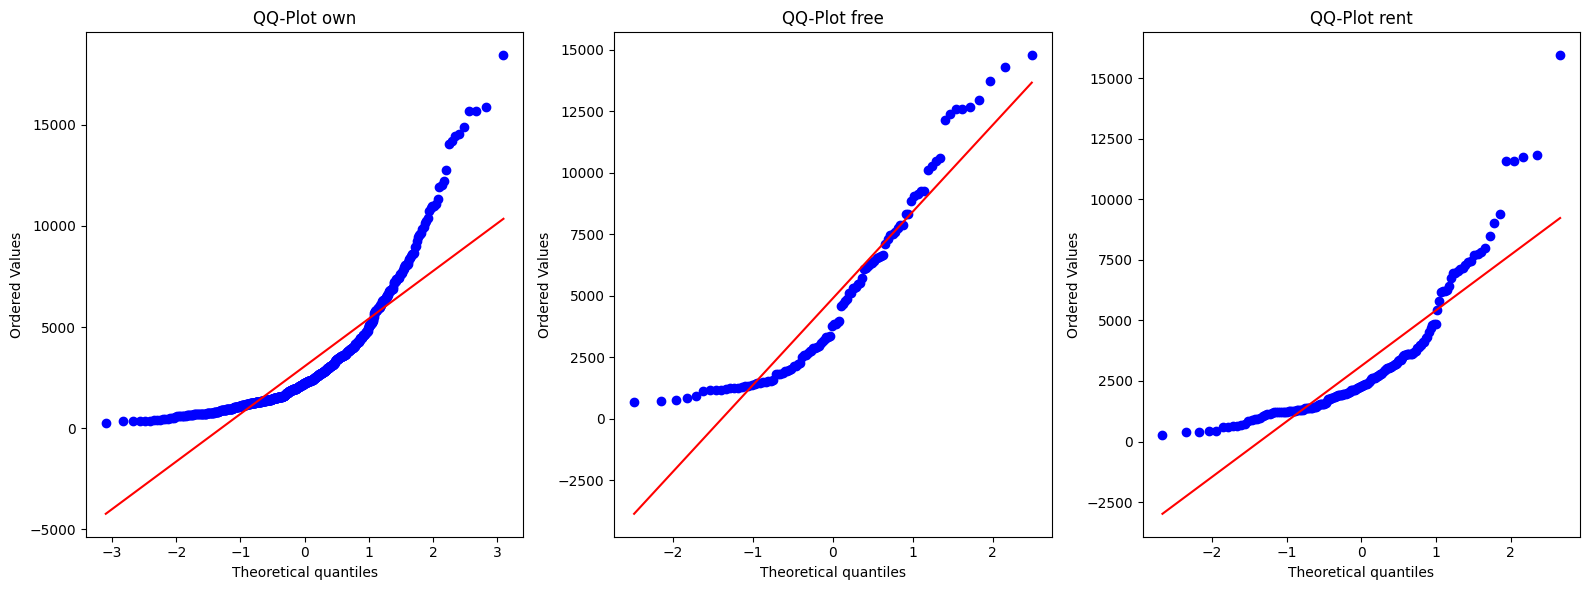

own p-value: 5.353233162990761e-30
free p-value: 2.1310467838049127e-07
rent p-value: 1.2413297364891487e-14


In [26]:
#qq-plot

fig, axes = plt.subplots(1, 3, figsize=(16, 6))

for i, var in enumerate(df['Housing'].unique()):
  x = df.loc[df['Housing'] == var, 'Credit amount']
  stats.probplot(x, plot=axes[i], dist='norm')
  axes[i].set_title(f"QQ-Plot {var}")

plt.tight_layout()
plt.show()

# Shapiro Test
for var in df['Housing'].unique():
  x = df.loc[df['Housing'] == var, 'Credit amount']
  test = stats.shapiro(x)
  print(f"{var} p-value: {test[1]}")


Since the null hypothesis of normality is rejected across all housing groups, we use the **Kruskal–Wallis test**:

- H₀: The distributions of the groups are equal  
- H₁: At least one group distribution differs from the others  


In [27]:
own = df.loc[df['Housing'] == 'own', 'Credit amount']
free = df.loc[df['Housing'] == 'free', 'Credit amount']
rent = df.loc[df['Housing'] == 'rent', 'Credit amount']
stats.kruskal(own, free, rent)

KruskalResult(statistic=np.float64(28.12532867231198), pvalue=np.float64(7.810205803636784e-07))

The statistical evidence indicates that credit amount distributions differ across housing groups.  


**Does Age Affect Credit Amount?**

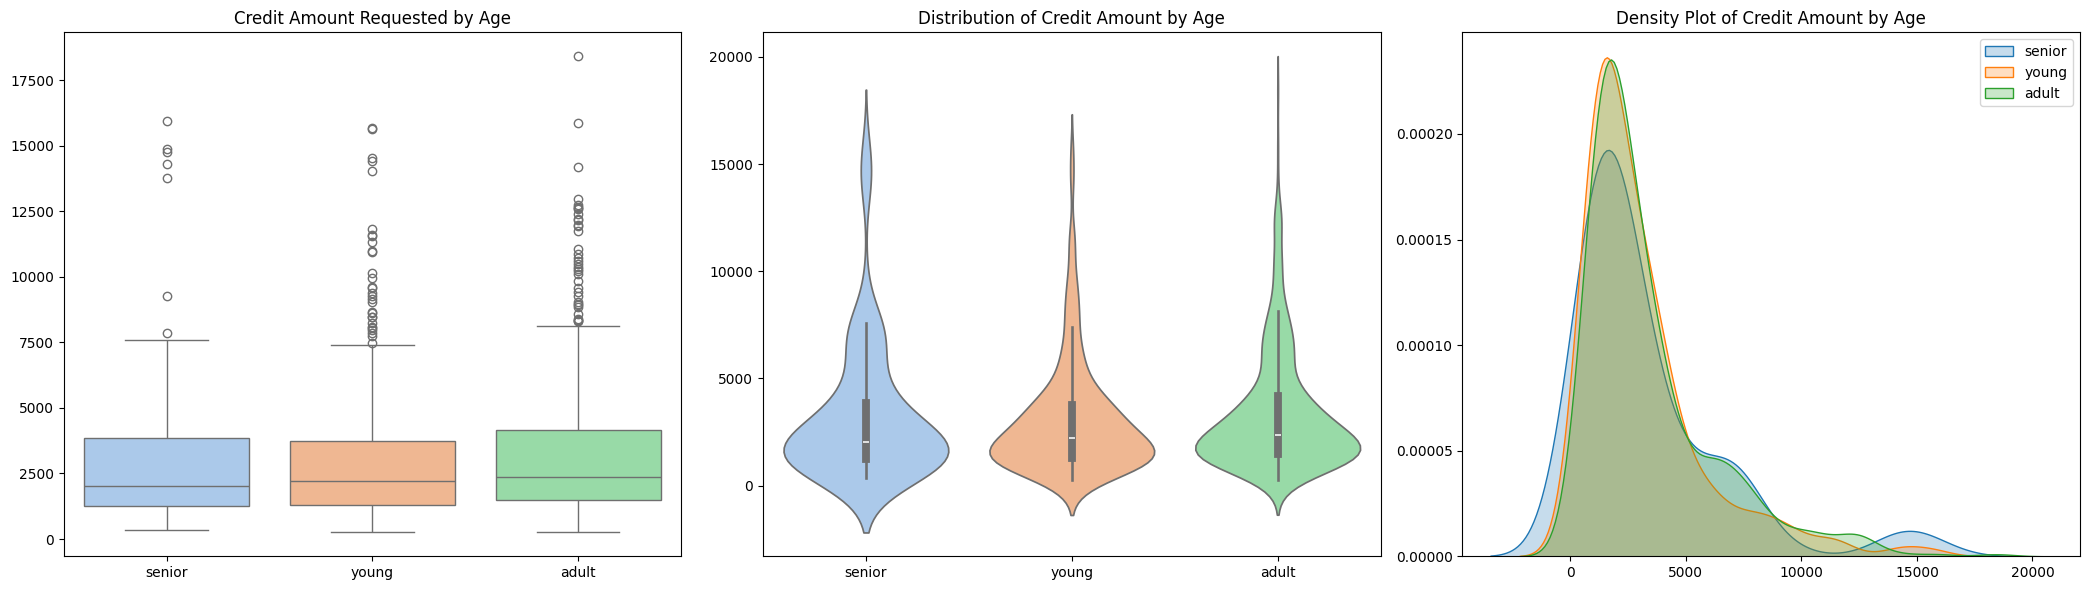

In [28]:
# Age clusters
def age_group(age):
    if age < 30:
        return 'young'
    elif 30 <= age <= 50:
        return 'adult'
    else:
        return 'senior'

df['age_group'] = df['Age'].apply(age_group)

# Plot

fig, axes = plt.subplots(1, 3, figsize=(21, 6))

# Boxplot of Credit Amount by Age cluster
sns.boxplot(data=df, x='age_group', y='Credit amount', palette='pastel', ax=axes[0], hue='age_group')
axes[0].set_title('Credit Amount Requested by Age')
axes[0].set_xlabel(None)
axes[0].set_ylabel(None)

# Violin plot of Credit Amount by Age cluster
sns.violinplot(data=df, x='age_group', y='Credit amount', palette='pastel', ax=axes[1], hue='age_group')
axes[1].set_title('Distribution of Credit Amount by Age')
axes[1].set_xlabel(None)
axes[1].set_ylabel(None)

# Density plot of Credit Amount by Age cluster
for housing in df['age_group'].unique():
    sns.kdeplot(df[df['age_group'] == housing]['Credit amount'], label=housing, fill=True, ax=axes[2])
axes[2].set_title('Density Plot of Credit Amount by Age')
axes[2].legend()
axes[2].set_xlabel(None)
axes[2].set_ylabel(None)

plt.tight_layout()
plt.show()


* **Young applicants** tend to request smaller and more uniform loan amounts.  
* **Adults** request the largest loans and show the greatest variability.  
* **Seniors** generally request small to moderate loans, with occasional very large amounts.  


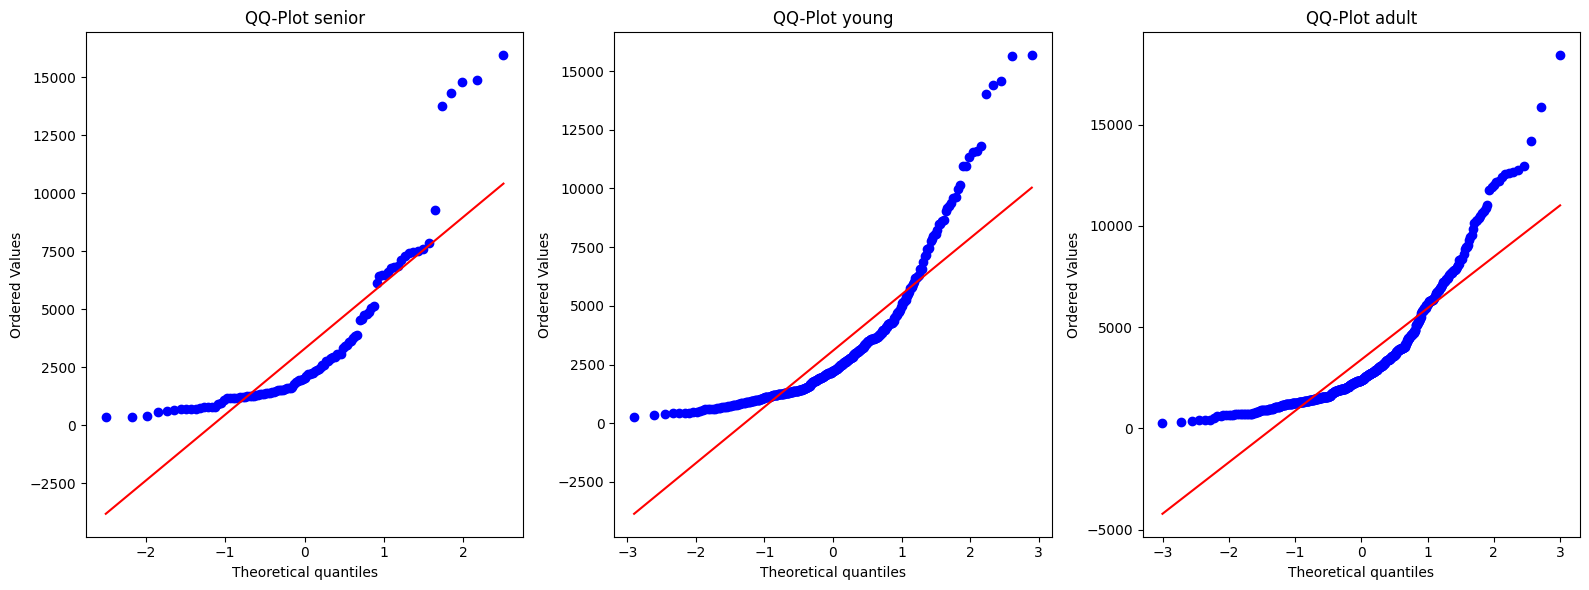

senior p-value: 8.71821027676452e-13
young p-value: 6.857266828877774e-22
adult p-value: 3.2546297902305272e-24


In [29]:
#QQ-plot

fig, axes = plt.subplots(1, 3, figsize=(16, 6))

for i, var in enumerate(df['age_group'].unique()):
  x = df.loc[df['age_group'] == var, 'Credit amount']
  stats.probplot(x, plot=axes[i], dist='norm')
  axes[i].set_title(f"QQ-Plot {var}")

plt.tight_layout()
plt.show()

# Shapiro Test
for var in df['age_group'].unique():
  x = df.loc[df['age_group'] == var, 'Credit amount']
  test = stats.shapiro(x)
  print(f"{var} p-value: {test[1]}")

In [30]:
senior = df.loc[df['age_group'] == 'senior', 'Credit amount']
young = df.loc[df['age_group'] == 'young', 'Credit amount']
adult = df.loc[df['age_group'] == 'adult', 'Credit amount']
stats.kruskal(senior, young, adult)

KruskalResult(statistic=np.float64(5.518866475262838), pvalue=np.float64(0.06332764991938632))

According to the statistical evidence, age groups come from different credit amount distributions.  


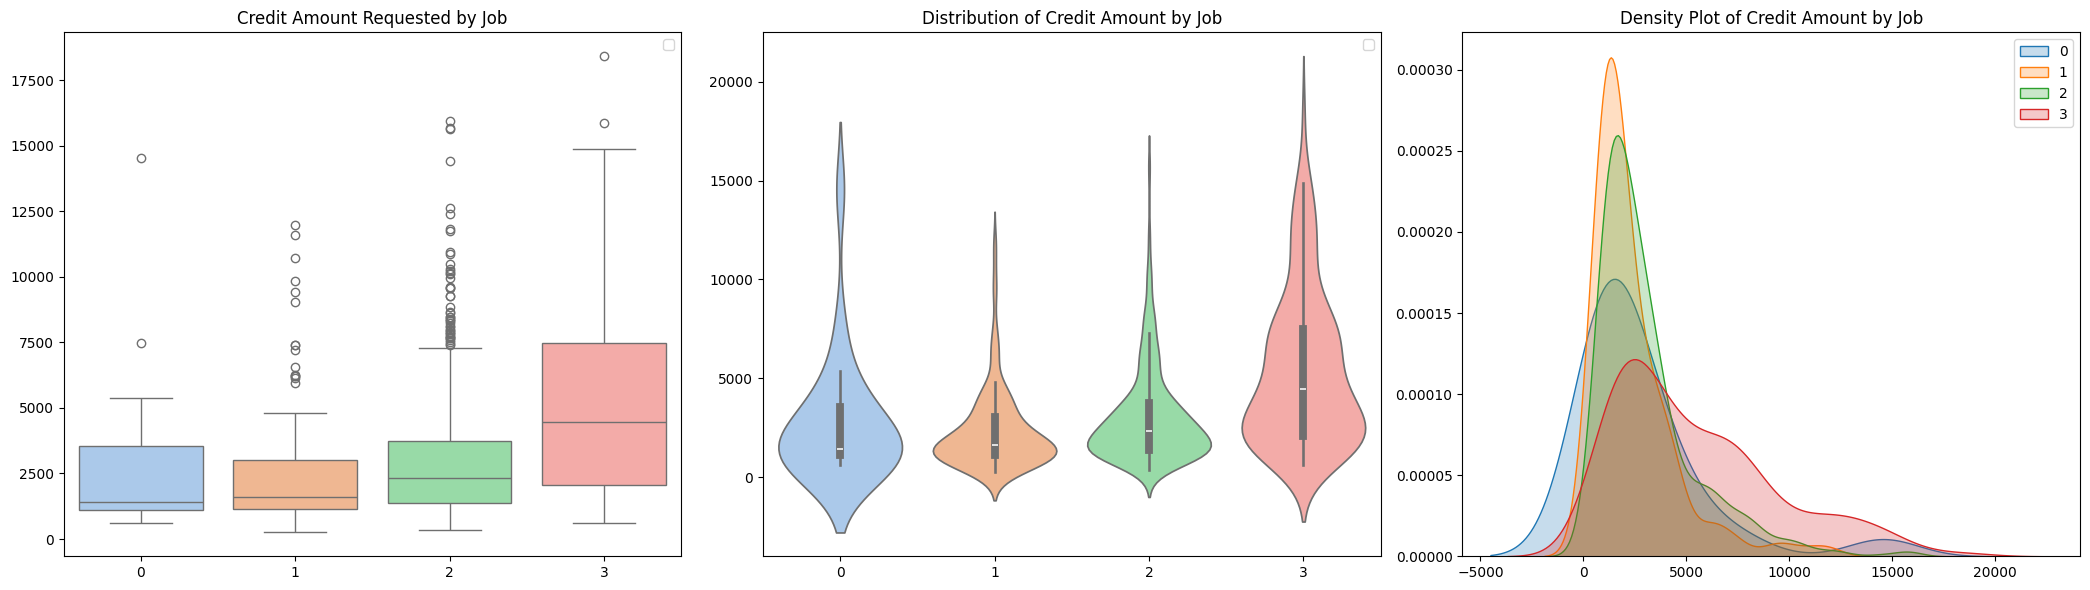

In [31]:
# Plot

fig, axes = plt.subplots(1, 3, figsize=(21, 6))

# Boxplot of Credit Amount by Job type
sns.boxplot(data=df, x='Job', y='Credit amount', palette='pastel', ax=axes[0], hue='Job')
axes[0].set_title('Credit Amount Requested by Job')
axes[0].legend([])
axes[0].set_xlabel(None)
axes[0].set_ylabel(None)

# Violin plot of Credit Amount by Job type
sns.violinplot(data=df, x='Job', y='Credit amount', palette='pastel', ax=axes[1], hue='Job')
axes[1].set_title('Distribution of Credit Amount by Job')
axes[1].legend([])
axes[1].set_xlabel(None)
axes[1].set_ylabel(None)

# Density plot of Credit Amount by Job type
for housing in df['Job'].sort_values().unique():
    sns.kdeplot(df[df['Job'] == housing]['Credit amount'], label=housing, fill=True, ax=axes[2])
axes[2].set_title('Density Plot of Credit Amount by Job')
axes[2].legend()
axes[2].set_xlabel(None)
axes[2].set_ylabel(None)

plt.tight_layout()
plt.show()


* There is a clear progression in credit amount: the more skilled the worker, the higher the requested credit, reflecting greater earning power likely associated with higher salaries.  
* **Unskilled workers** (Job 0, Job 1) request the smallest loans and show very limited variability, with only a few extreme cases.  
* **Skilled workers** (Job 2) request larger loans with broader variability.  
* **Highly skilled workers** (Job 3) request the largest and most variable loans, with many high-value credits.  


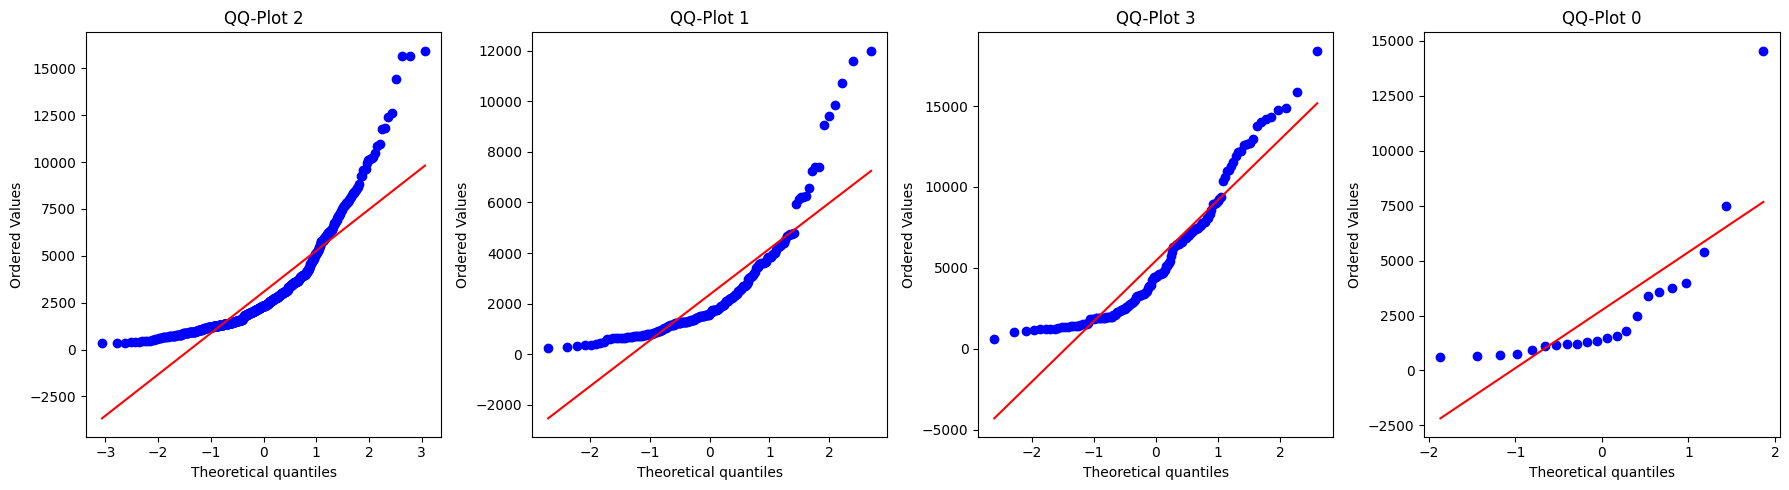

Job 2 p-value: 9.151936596486235e-27
Job 1 p-value: 9.039787327067147e-17
Job 3 p-value: 6.686287230602938e-09
Job 0 p-value: 5.019618135483232e-06


In [32]:
from scipy.stats import shapiro

#QQ-plot

fig, axes = plt.subplots(1, 4, figsize=(18, 5))

for i, var in enumerate(df['Job'].unique()):
  x = df.loc[df['Job'] == var, 'Credit amount']
  stats.probplot(x, plot=axes[i], dist='norm')
  axes[i].set_title(f"QQ-Plot {var}")

plt.tight_layout()
plt.show()

# Shapiro Test
for var in df['Job'].unique():
  x = df.loc[df['Job'] == var, 'Credit amount']
  test = stats.shapiro(x)
  print(f"Job {var} p-value: {test[1]}")

In [33]:
Job0 = df.loc[df['Job'] == 0, 'Credit amount']
Job1 = df.loc[df['Job'] == 1, 'Credit amount']
Job2 = df.loc[df['Job'] == 2, 'Credit amount']
Job3 = df.loc[df['Job'] == 3, 'Credit amount']
stats.kruskal(Job0, Job1, Job2, Job3)

KruskalResult(statistic=np.float64(95.40412341069586), pvalue=np.float64(1.5116947854411372e-20))

The statistical evidence indicates that credit amount distributions differ across job groups.  


#### Credit Amount and the Interaction of Sex, Age Group, and Housing

This section analyzes how the interaction between **Sex**, **Age Group**, and **Housing** affects the requested credit amount.  

To address this, we build an **OLS model**, which relies on the normality assumption of the residuals. Applying a natural log transformation to the credit amount helps improve this assumption.  




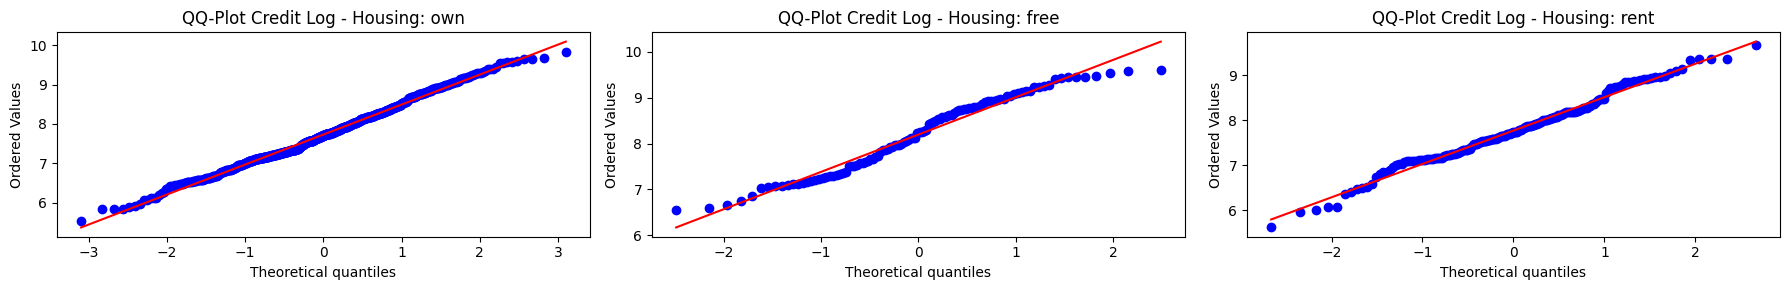

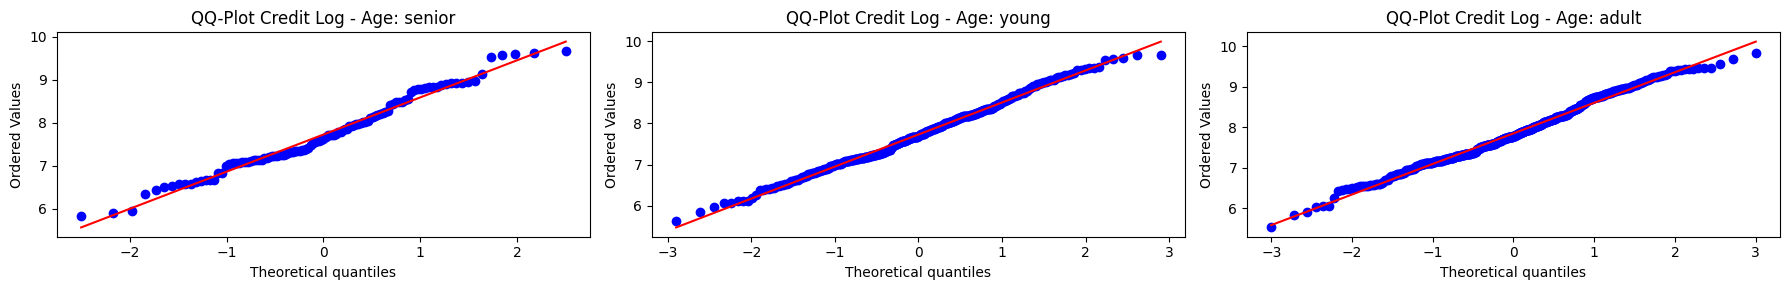

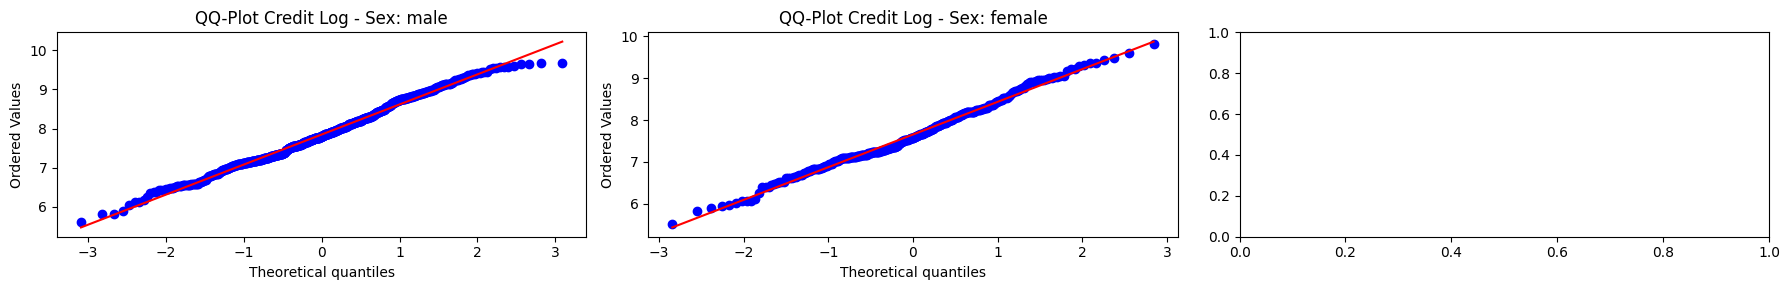

In [34]:
# Natural log of Credit Amount
df['Credit_log'] = np.log(df['Credit amount'])

#QQ-plot

fig, axes = plt.subplots(1, 3, figsize=(18, 3))

for i, var in enumerate(df['Housing'].unique()):
  x = df.loc[df['Housing'] == var, 'Credit_log']
  stats.probplot(x, plot=axes[i], dist='norm')
  axes[i].set_title(f"QQ-Plot Credit Log - Housing: {var}")

plt.tight_layout()
plt.show()

print()

fig, axes = plt.subplots(1, 3, figsize=(18, 3))

for i, var in enumerate(df['age_group'].unique()):
  x = df.loc[df['age_group'] == var, 'Credit_log']
  stats.probplot(x, plot=axes[i], dist='norm')
  axes[i].set_title(f"QQ-Plot Credit Log - Age: {var}")

plt.tight_layout()
plt.show()

print()

fig, axes = plt.subplots(1, 3, figsize=(18, 3))

for i, var in enumerate(df['Sex'].unique()):
  x = df.loc[df['Sex'] == var, 'Credit_log']
  stats.probplot(x, plot=axes[i], dist='norm')
  axes[i].set_title(f"QQ-Plot Credit Log - Sex: {var}")

plt.tight_layout()
plt.show()


In [35]:
# OLS model
model = ols(
    'Q("Credit_log") ~ C(age_group) + C(Sex) + C(Housing) + C(age_group):C(Sex) + C(age_group):C(Housing) + C(Sex):C(Housing)', data=df).fit()

# ANOVA test
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)


                             sum_sq     df          F        PR(>F)
C(age_group)               2.793880    2.0   2.433265  8.827660e-02
C(Sex)                     5.665758    1.0   9.868924  1.731049e-03
C(Housing)                20.146067    2.0  17.545753  3.254167e-08
C(age_group):C(Sex)        0.621993    2.0   0.541710  5.819254e-01
C(age_group):C(Housing)    5.121885    4.0   2.230394  6.389679e-02
C(Sex):C(Housing)          1.311033    2.0   1.141814  3.196610e-01
Residual                 566.063516  986.0        NaN           NaN


* The interaction between **Age** and **Gender** is not significant: the gender effect does not depend on age group.  
* The interaction between **Age** and **Housing** is significant at the 10% level, providing weak evidence that the housing effect may depend on age group.  
* The interaction between **Gender** and **Housing** is not significant: the housing effect does not depend on gender.  

---

* The main effects of **Gender** and **Housing** confirm the earlier results.  
* The **Age group** effect is now significant at the 10% level, whereas it was previously significant at the 5% level. This may be because, after controlling for other variables, part of the variance previously attributed to Age group is now explained by other regressors.  


#### Credit Risk and Its Relationship with Key Categorical Variables

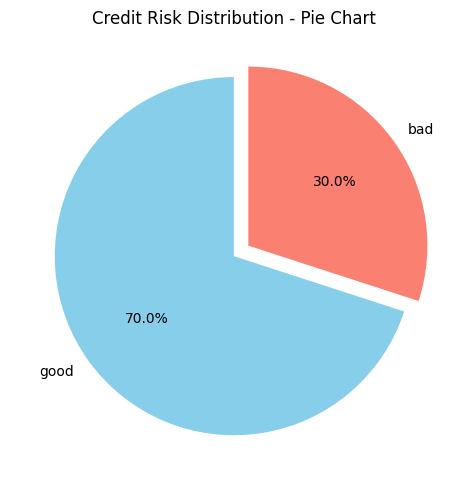

In [36]:
risk_count = df['Risk'].value_counts()

explode = [0, 0]
min_idx = risk_count.idxmin()
if min_idx == risk_count.index[0]:
    explode[0] = 0.1
else:
    explode[1] = 0.1

plt.figure(figsize=(17, 5))

# Pie chart with explode
plt.pie(risk_count, labels=risk_count.index, autopct='%1.1f%%', colors=['skyblue', 'salmon'],startangle=90, explode=explode)
plt.title('Credit Risk Distribution - Pie Chart')

plt.tight_layout()
plt.show()


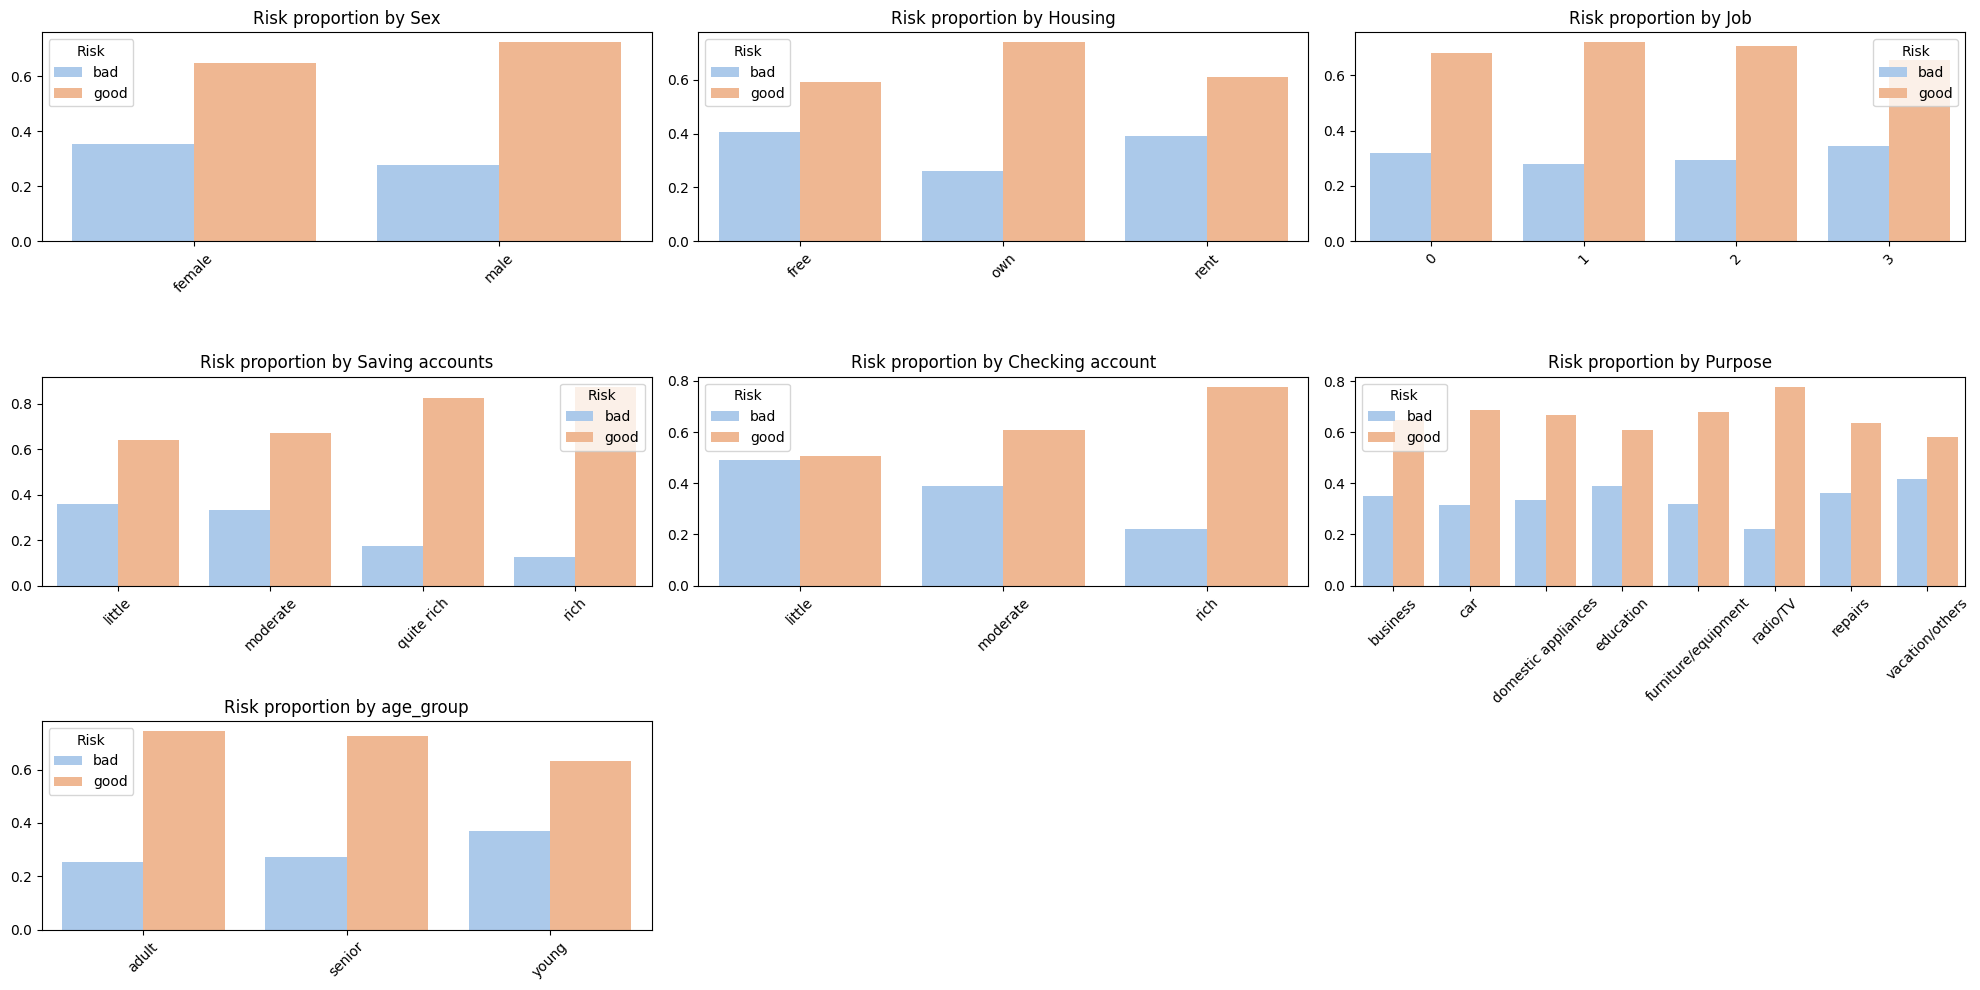

In [37]:
categorical_cols = ['Sex', 'Housing', 'Job', 'Saving accounts', 'Checking account', 'Purpose', 'age_group']

fig, axes = plt.subplots(3, 3, figsize=(20, 10))
axes = axes.flatten()

for i, col in enumerate(categorical_cols):
    prop_df = pd.crosstab(df[col], df['Risk'], normalize='index')
    prop_long = prop_df.reset_index().melt(id_vars=col, var_name='Risk', value_name='Proportion')
    sns.barplot(data=prop_long, x=col, y='Proportion', hue='Risk', ax=axes[i], palette='pastel')
    axes[i].set_title(f'Risk proportion by {col}')
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].set_xlabel(None)
    axes[i].set_ylabel(None)

# Hide the remaining unused subplots (from index 7 onward)
for j in range(len(categorical_cols), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


* **Strong predictors of risk**:  
  - **Savings accounts** → higher savings correspond to much lower default rates.  
  - **Checking account** → strong gradient; accounts marked as “little” are especially risky.  
  - **Housing** → homeowners are the safest, while renters or those living rent-free are riskier.  
  - **Purpose** → substantial differences across categories.  
  - **Age** → younger applicants are riskier.  

* **Weaker predictors of risk**:  
  - **Sex** → small difference, with men slightly safer.  
  - **Job** → some variation, but weaker compared to financial variables.  


/tmp/ipython-input-243892478.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  g = sns.catplot(


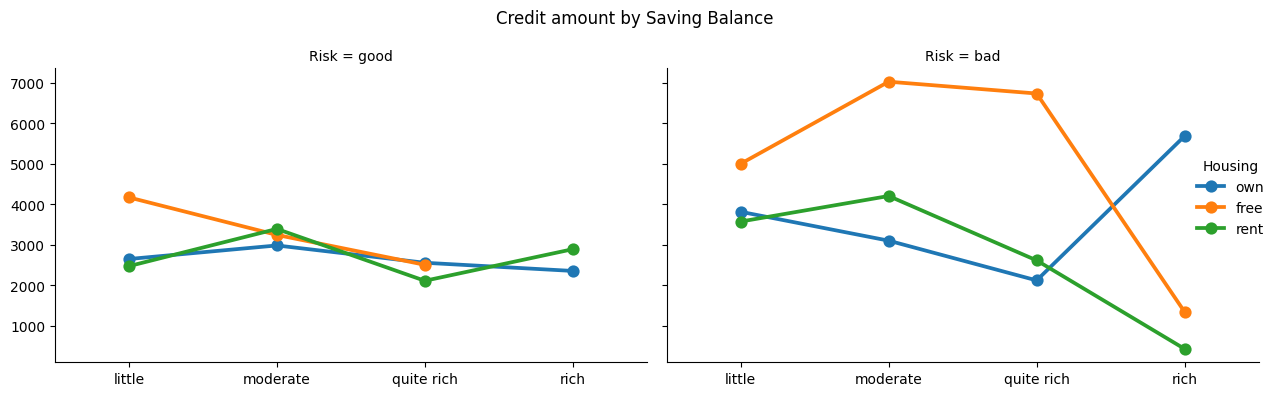

In [38]:
saving_order = ['little','moderate','quite rich','rich']
g = sns.catplot(
    data=df,
    x="Saving accounts",
    y="Credit amount",
    hue="Housing",
    col="Risk",
    kind="point",
    ci=None,
    height=4,
    aspect=1.5,
    order=saving_order
)

# Set common axis labels
g.set_axis_labels("","")

# Set a common title across the whole grid
g.fig.suptitle("Credit amount by Saving Balance")

# Optional: adjust spacing so the title doesn’t overlap
g.fig.tight_layout()


* **Bad-risk customers** show more extreme and volatile patterns: their requested amounts fluctuate sharply depending on savings and housing, unlike good-risk customers.  
* Bad-risk customers with **high savings and home ownership** request the largest loans.  
* Bad-risk customers with **free housing** request large loans at moderate savings levels, but if they are “rich,” the amounts drop drastically.  

Overall, this chart suggests that **risk interacts strongly with savings and housing** in shaping loan size.  
Good-risk customers borrow relatively consistent amounts regardless of their savings level, while bad-risk customers display erratic borrowing patterns — especially large requests in certain savings–housing combinations (e.g., rich + own, or moderate + free).  


/tmp/ipython-input-3495948652.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  g = sns.catplot(


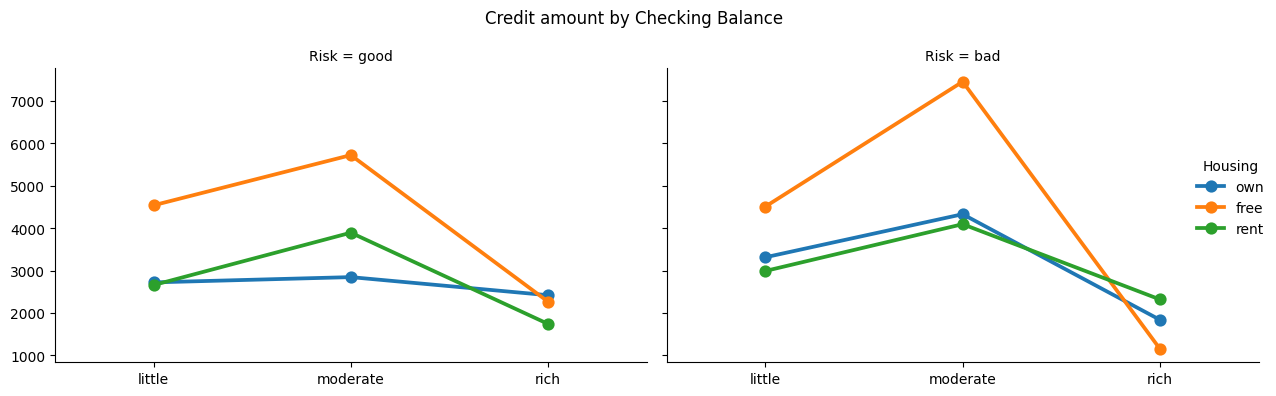

In [39]:
saving_order = ['little','moderate','rich']
g = sns.catplot(
    data=df,
    x="Checking account",
    y="Credit amount",
    hue="Housing",
    col="Risk",
    kind="point",
    ci=None,
    height=4,
    aspect=1.5,
    order=saving_order
)

# Set common axis labels
g.set_axis_labels("","")

# Set a common title across the whole grid
g.fig.suptitle("Credit amount by Checking Balance")

# Optional: adjust spacing so the title doesn’t overlap
g.fig.tight_layout()


Risk differences are most evident in the **moderate savings** category, where free housing creates a large gap, particularly among bad-risk customers.  


### Relationship Between Credit Amount, Duration, and Risk

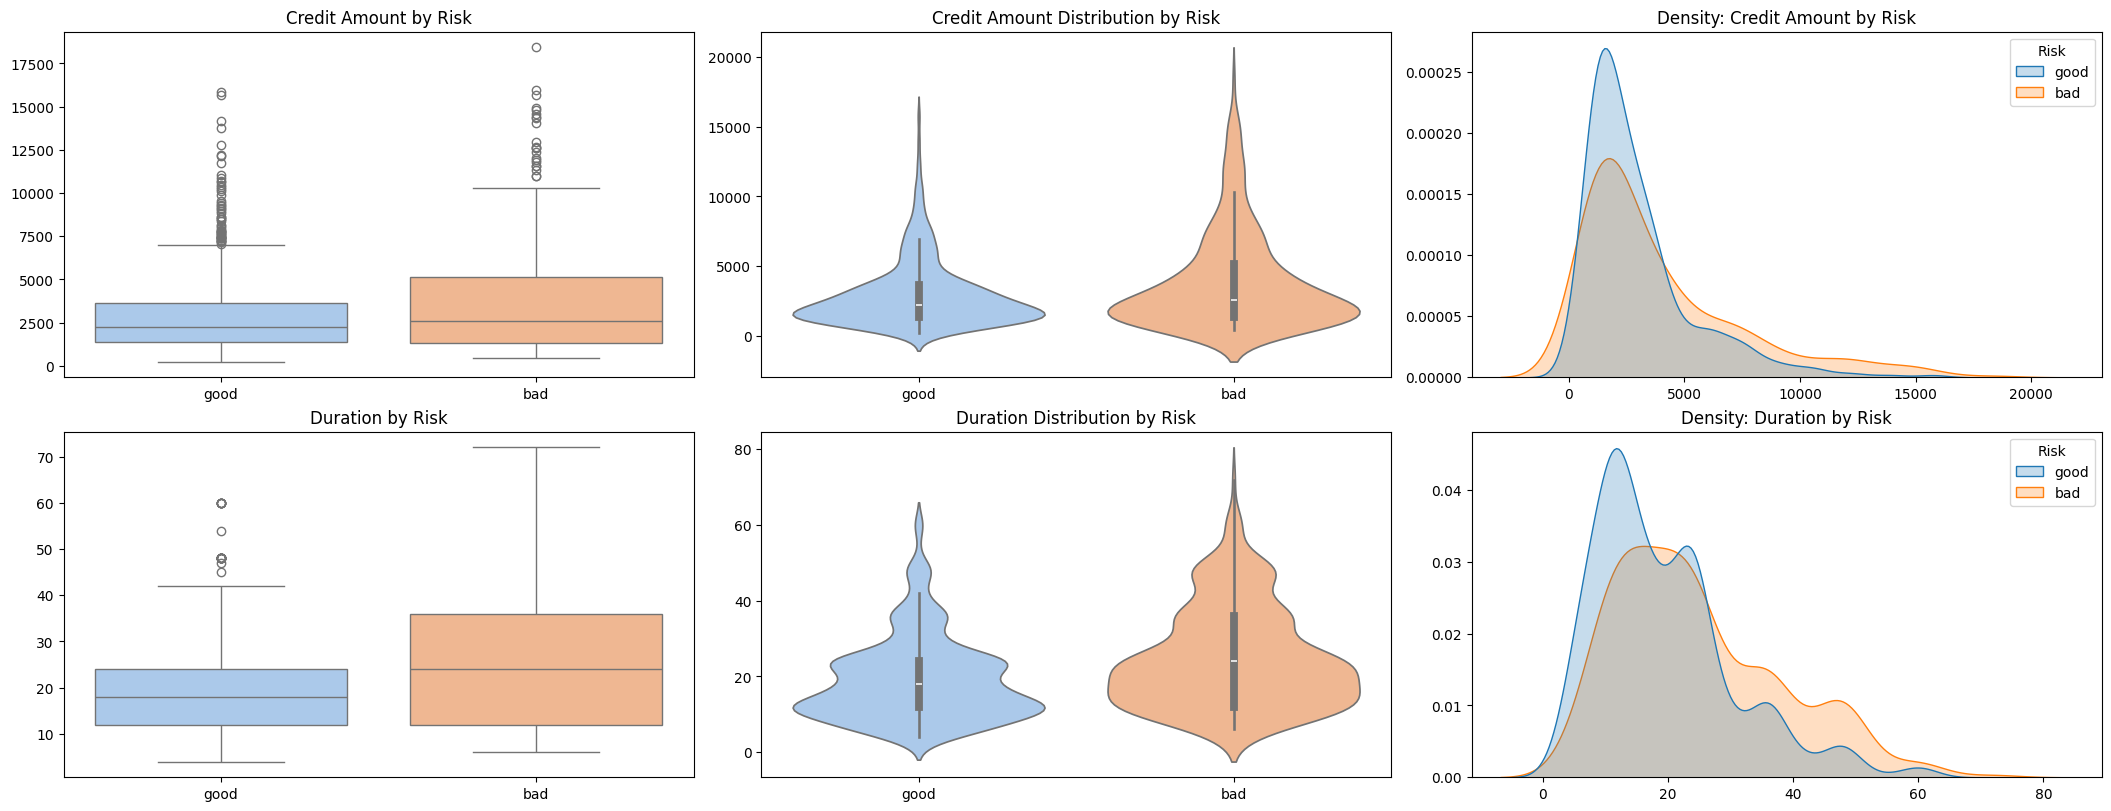

In [40]:
fig, axes = plt.subplots(2, 3, figsize=(21, 8), constrained_layout=True)

# Boxplot of Credit Amount by Risk
sns.boxplot(data=df, x='Risk', y='Credit amount', palette='pastel', ax=axes[0, 0], hue='Risk')
axes[0, 0].set_title('Credit Amount by Risk')

# Violin plot of Credit Amount by Risk
sns.violinplot(data=df, x='Risk', y='Credit amount', palette='pastel', ax=axes[0, 1], hue='Risk')
axes[0, 1].set_title('Credit Amount Distribution by Risk')

# Density plot of Credit Amount by Risk
sns.kdeplot(
    data=df.dropna(subset=['Credit amount', 'Risk']),
    x='Credit amount', hue='Risk', fill=True, common_norm=False, ax=axes[0, 2]
)
axes[0, 2].set_title('Density: Credit Amount by Risk')

# Boxplot of Duration by Risk
sns.boxplot(data=df, x='Risk', y='Duration', palette='pastel', ax=axes[1, 0], hue='Risk')
axes[1, 0].set_title('Duration by Risk')

# Violin plot of Duration by Risk
sns.violinplot(data=df, x='Risk', y='Duration', palette='pastel', ax=axes[1, 1], hue='Risk')
axes[1, 1].set_title('Duration Distribution by Risk')

# Density plot of Duration by Risk
sns.kdeplot(
    data=df.dropna(subset=['Duration', 'Risk']),
    x='Duration', hue='Risk', fill=True, common_norm=False, ax=axes[1, 2]
)
axes[1, 2].set_title('Density: Duration by Risk')

# Optional: tidy labels
for ax in axes.ravel():
    ax.set_xlabel('')
    ax.set_ylabel('')

plt.show()


* **Larger requested credit amounts** are more frequently associated with bad risk:  
  - The median is higher for bad-risk customers  
  - The bad-risk group shows a wider spread  
  - Bad-risk borrowers tend to request larger loans overall  

* **Longer loan durations** are strongly associated with bad risk:  
  - The median duration is much higher, and the interquartile range is wider  
  - Good-risk borrowers peak strongly around shorter durations (≈20 months), while bad-risk borrowers follow a longer-tailed distribution  


In [41]:
# Shapiro test

bad_risk_credit = df.loc[df['Risk'] == 'bad', 'Credit amount']
good_risk_credit = df.loc[df['Risk'] == 'good', 'Credit amount']

bad_risk_duration = df.loc[df['Risk'] == 'bad', 'Duration']
good_risk_duration = df.loc[df['Risk'] == 'good', 'Duration']

stat_b, p_b = stats.shapiro(bad_risk_credit)
stat_g, p_g = stats.shapiro(good_risk_credit)
print(f"\nBad Risk Shapiro p-value: {p_b}")
print(f"Good Risk Shapiro p-value: {p_g}")

stat_b, p_b = stats.shapiro(bad_risk_duration)
stat_g, p_g = stats.shapiro(good_risk_duration)
print(f"\nBad Risk Shapiro p-value: {p_b}")
print(f"Good Risk Shapiro p-value: {p_g}")


Bad Risk Shapiro p-value: 2.841586067065008e-18
Good Risk Shapiro p-value: 5.184836501214235e-28

Bad Risk Shapiro p-value: 6.478560226120272e-12
Good Risk Shapiro p-value: 1.5303819115920924e-21


Both **Duration** and **Credit Amount** deviate from normality according to the test results.  


In [42]:
# Mann–Whitney U Test
stat, p = mannwhitneyu(bad_risk_credit, good_risk_credit, alternative='two-sided')

print('Credit amount test:')
print(f"Mann–Whitney U statistic: {stat}")
print(f"P-value: {p}")

stat, p = mannwhitneyu(bad_risk_duration, good_risk_duration, alternative='two-sided')

print('\nDuration test:')
print(f"Mann–Whitney U statistic: {stat}")
print(f"P-value: {p}")

Credit amount test:
Mann–Whitney U statistic: 116520.0
P-value: 0.005917609166184079

Duration test:
Mann–Whitney U statistic: 132004.5
P-value: 7.981665531518925e-11


The evidence suggests that both **Credit Amount** and **Duration** affect Risk, as they are statistically significant predictors:  
* There is no statistical evidence that credit amount distributions belong to the same population across risk groups.  
* There is no statistical evidence that duration distributions belong to the same population across risk groups.  

Therefore, the tests confirm that **risky borrowers tend to request larger loans with longer durations**.  


### Relationship Between Categorical Variables and Risk

**Chi-Square Test**

- H₀: There is no association between the two categorical variables (they are independent).  
- H₁: There is an association between the two categorical variables (they are not independent).  


In [43]:
from scipy.stats import chi2_contingency

# List of categorical variables to test against 'Risk'
categorical_vars = ['Sex', 'Housing', 'Job', 'Saving accounts', 'Purpose', 'age_group']

for var in categorical_vars:
    print(f"\nContingency table: Risk vs {var}")

    # Create contingency table
    contingency = pd.crosstab(df['Risk'], df[var])

    # Chi-square test
    test = chi2_contingency(contingency)
    p = test.pvalue

    if p < 0.05:
        print("Significant association (Reject H0: variables are NOT independent)")
    else:
        print("No significant association (Fail to reject H0: variables may be independent)")



Contingency table: Risk vs Sex
Significant association (Reject H0: variables are NOT independent)

Contingency table: Risk vs Housing
Significant association (Reject H0: variables are NOT independent)

Contingency table: Risk vs Job
No significant association (Fail to reject H0: variables may be independent)

Contingency table: Risk vs Saving accounts
Significant association (Reject H0: variables are NOT independent)

Contingency table: Risk vs Purpose
No significant association (Fail to reject H0: variables may be independent)

Contingency table: Risk vs age_group
Significant association (Reject H0: variables are NOT independent)


**Cramér's V statistic**: measures the strength of the association between two categorical variables.  


In [44]:
categorical_vars = ['Sex', 'Housing', 'Job', 'Saving accounts', 'Checking account', 'Purpose', 'age_group']

for var in categorical_vars:
    print(f"\nContingency table: Risk vs {var}")

    # Create contingency table
    contingency = pd.crosstab(df['Risk'], df[var])
    chi2, p, dof, expected = chi2_contingency(contingency)

    # Sample size
    n = contingency.values.sum()
    # Min dimension of contingency table
    min_dim = min(contingency.shape)

    # Cramér's V
    cramer_v = np.sqrt(chi2 / (n * (min_dim - 1)))

    # Print results
    print(f"Chi-square p-value: {p:.4f} -> {'Significant association' if p < 0.05 else 'No significant association'}")
    print(f"Cramér's V: {cramer_v:.3f}")




Contingency table: Risk vs Sex
Chi-square p-value: 0.0207 -> Significant association
Cramér's V: 0.073

Contingency table: Risk vs Housing
Chi-square p-value: 0.0001 -> Significant association
Cramér's V: 0.135

Contingency table: Risk vs Job
Chi-square p-value: 0.5966 -> No significant association
Cramér's V: 0.043

Contingency table: Risk vs Saving accounts
Chi-square p-value: 0.0004 -> Significant association
Cramér's V: 0.150

Contingency table: Risk vs Checking account
Chi-square p-value: 0.0002 -> Significant association
Cramér's V: 0.168

Contingency table: Risk vs Purpose
Chi-square p-value: 0.0579 -> No significant association
Cramér's V: 0.117

Contingency table: Risk vs age_group
Chi-square p-value: 0.0011 -> Significant association
Cramér's V: 0.117


### Conclusions

The analysis highlights the following main insights:  

* **Duration** and **Credit Amount** are higher among bad-risk borrowers.  
* **Checking account** and **Saving account** show the strongest associations with Risk among categorical variables (small-to-moderate effects).  
* **Housing**, **Sex**, and **Age group** are associated with Risk, while **Job** and **Purpose** are not.  
* **Credit Amount** varies significantly across Job and Housing groups, but not across Age groups.  
